In [ ]:
!pip install pprint ipywidgets pandas numpy matplotlib sklearn seaborn xgboost scipy yellowbrick statsmodels pandas_profiling

In [1]:
!pip install dask dask_ml

Defaulting to user installation because normal site-packages is not writeable


# Gusto

Acute myocardial infarction (“heart attack”) is caused by the formation of a clot in oneof the coronary arteries that supply blood to the heart muscle. 

Acute MI is a major public health problem. Mortality is substantial in the period immediately after the event (and also during the years after surviving the initial  infarction). Some patients die before reaching the  hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%, with improvement over time. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics includethe location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patients reflected by blood pressure,heart rate, and left ventricular function (e.g., presence of shock).

Aim of this study is to find predictors of 30-days mortality. 

In [81]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pprint import pprint
from time import sleep

#  load data
import pandas as pd
import numpy as np
import dask.dataframe as dd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator

import tpot

import xgboost as xgb

from scipy.special import expit

from yellowbrick.classifier import ConfusionMatrix, ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas_profiling import ProfileReport

In [92]:
df = pd.read_csv("./Gusto.csv")

# dummify smk categories
df['eversmk']= (df['smk']!=1).astype(int)
df['currentsmk']=(df['smk']==3).astype(int)
df.drop(["smk"], axis=1)
df.describe()

,day30,sex,age,a65,killip,sho,dia,hyp,hrt,ant,...,htn,smk,lip,pan,fam,ste,st4,ttr,eversmk,currentsmk
count,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,...,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000
mean,0.063098,0.256760,60.849984,0.394428,1.157334,0.016935,0.131385,0.087135,0.317126,0.367932,...,0.396340,1.883638,0.397432,0.350178,0.456706,4.060093,0.368479,0.589456,0.603660,0.279978
std,0.243171,0.436906,11.805047,0.488794,0.432737,0.129047,0.337867,0.282071,0.465421,0.482309,...,0.489203,0.814223,0.489434,0.477091,0.498190,1.874387,0.482458,0.492000,0.489203,0.449050
min,0.000000,0.000000,23.910000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,51.547000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,61.266000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000
75%,0.000000,1.000000,70.094000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,89.484000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
# any null value?
bool(df.isnull().sum().sum())

False

In [94]:
# dropping useless/redundant columns
df.drop(["sho", "a65", "st4"], axis=1)
df.columns

Index(['day30', 'sex', 'age', 'a65', 'killip', 'sho', 'dia', 'hyp', 'hrt',
       'ant', 'pmi', 'hei', 'wei', 'htn', 'smk', 'lip', 'pan', 'fam', 'ste',
       'st4', 'ttr', 'eversmk', 'currentsmk'],
      dtype='object')

In [85]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])

In [86]:
from tpot import TPOTClassifier

In [87]:
pipeline_optimizer = TPOTClassifier()

In [90]:
pipeline_optimizer = TPOTClassifier(generations=15, population_size=30, cv=5,
                                    random_state=42, verbosity=2)

In [91]:
pipeline_optimizer.fit(x_train, y_train)


Generation 1 - Current best internal CV score: 0.9508196721311476
Generation 2 - Current best internal CV score: 0.9508196721311476
Generation 3 - Current best internal CV score: 0.9508196721311476
Generation 4 - Current best internal CV score: 0.9526411657559197
Generation 5 - Current best internal CV score: 0.9526411657559197
Generation 6 - Current best internal CV score: 0.9526411657559197
Generation 7 - Current best internal CV score: 0.9526411657559197
Generation 8 - Current best internal CV score: 0.9526411657559197
Generation 9 - Current best internal CV score: 0.9526411657559197
Generation 10 - Current best internal CV score: 0.9526411657559197
Generation 11 - Current best internal CV score: 0.9526411657559197
Generation 12 - Current best internal CV score: 0.9526411657559197
Generation 13 - Current best internal CV score: 0.9526411657559197
Generation 14 - Current best internal CV score: 0.9526411657559197
Generation 15 - Current best internal CV score: 0.9526411657559197
Bes

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=15,
               log_file=<ipykernel.iostream.OutStream object at 0x7fd7d21d3b38>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=30,
               random_state=42, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [73]:
print(pipeline_optimizer.score(x_test, y_test))

0.9563318777292577


In [74]:
pipeline_optimizer.export('1.py')

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file

features = df.drop('day30', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, df['day30'], random_state=42)

# Average CV score on the training set was: 0.9522768670309654
exported_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=32, p=2, weights="distance")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

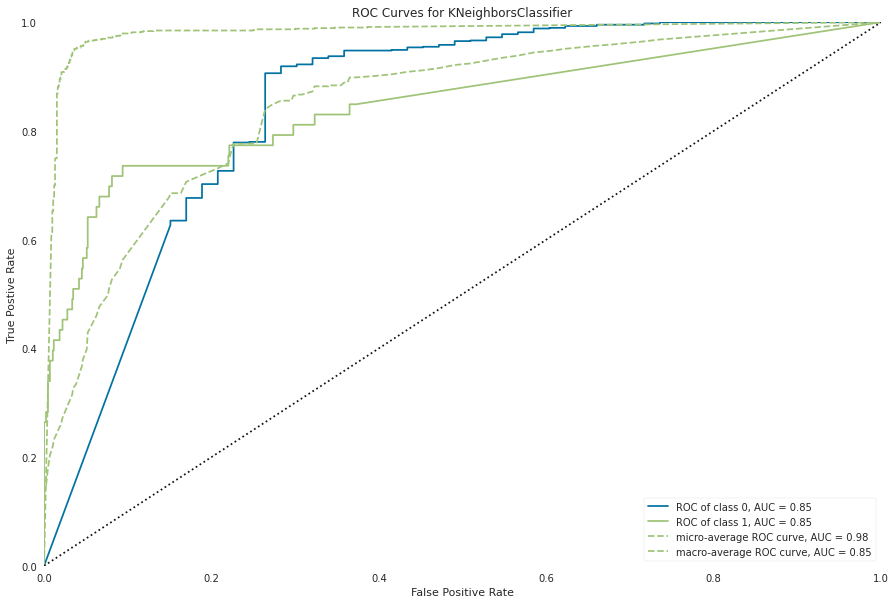

In [80]:
from yellowbrick.classifier import ROCAUC

rocauc = ROCAUC(exported_pipeline, size=(1080, 720))

rocauc.score(x_test, y_test)  
r = rocauc.poof()